# Análisis exploratorio y baseline clásico – Brain Tumor (BRATS)
Este notebook realiza un pequeño *pipeline* completo con:
1. **Carga de los volúmenes** (`imagesTr` y `labelsTr`).
2. **Exploración básica** (dimensiones, conteo de clases por *slice*, visualización de ejemplos).
3. **Pre‑procesamiento**
   * Normalización a `[0,1]`.
   * Redimensionado a `64×64` por *slice*.
   * Conversión de volúmenes 3‑D en un conjunto de *slices* 2‑D etiquetadas.
4. **Balanceo simple** mediante *undersampling* de la clase mayoritaria.
5. **Baseline clásico** (`PCA` → `LogisticRegression`).

> **NOTA**: todo el flujo es **clásico**. Luego podrías sustituir la etapa 5 por un circuito de QML con el *embedding* que prefieras (Angle, Hilbert, etc.).

## 0. Dependencias
Ejecuta la celda siguiente para instalar paquetes que falten en tu entorno (solo la primera vez):

In [1]:
!pip install -q nibabel scikit-image scikit-learn tqdm

## 1. Carga de rutas y utilidades

In [2]:
import os, glob, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from tqdm import tqdm
import seaborn as sns

DATA_DIR = 'data'              # ajusta según tu árbol
IMG_DIR  = os.path.join(DATA_DIR, 'imagesTr')
MASK_DIR = os.path.join(DATA_DIR, 'labelsTr')

def is_valid(fname):
    """Descarta archivos ocultos de macOS (._*) y comprueba extensión .nii o .nii.gz"""
    return (fname.endswith('.nii') or fname.endswith('.nii.gz')) and not fname.startswith('._')

image_files = sorted([f for f in os.listdir(IMG_DIR) if is_valid(f)])
print(f'Encontradas {len(image_files)} imágenes en {IMG_DIR}')

Encontradas 484 imágenes en data\imagesTr


### Funciones helper para cargar volúmenes y extraer *slices*

In [3]:
def load_pair(image_fname):
    """Devuelve (volumen_img, volumen_mask) como floats."""
    img_path  = os.path.join(IMG_DIR, image_fname)
    mask_path = os.path.join(MASK_DIR, image_fname)         # mismo nombre
    img  = nib.load(img_path).get_fdata().astype(np.float32)
    mask = nib.load(mask_path).get_fdata().astype(np.float32)
    return img, mask

def extract_slices(img, mask, axis=2, step=1, resize_to=(64,64)):
    """Convierte un volumen 3‑D en lista de (x_slice, y_label).
"
    La etiqueta será 1 si existe algún voxel positivo en la máscara."""
    slices, labels = [], []
    for idx in range(0, img.shape[axis], step):
        if axis==0:
            img_sl, mask_sl = img[idx,:,:], mask[idx,:,:]
        elif axis==1:
            img_sl, mask_sl = img[:,idx,:], mask[:,idx,:]
        else:
            img_sl, mask_sl = img[:,:,idx], mask[:,:,idx]
        label = 1 if np.any(mask_sl) else 0
        # escala 0‑1 y resize
        img_sl = (img_sl - img_sl.min()) / (np.ptp(img_sl) + 1e-8)

        img_sl = resize(img_sl, resize_to, mode='reflect', anti_aliasing=True)
        slices.append(img_sl.astype(np.float32))
        labels.append(label)
    return slices, labels


## 2. Exploración rápida

Extrayendo slices: 100%|██████████| 484/484 [05:21<00:00,  1.50it/s]


Total slices: (37752, 64, 64, 4) positivos: 16882


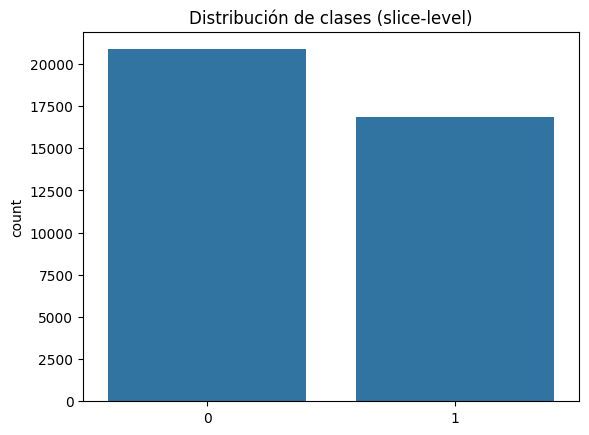

Total slices: (37752, 64, 64, 4) positivos: 16882


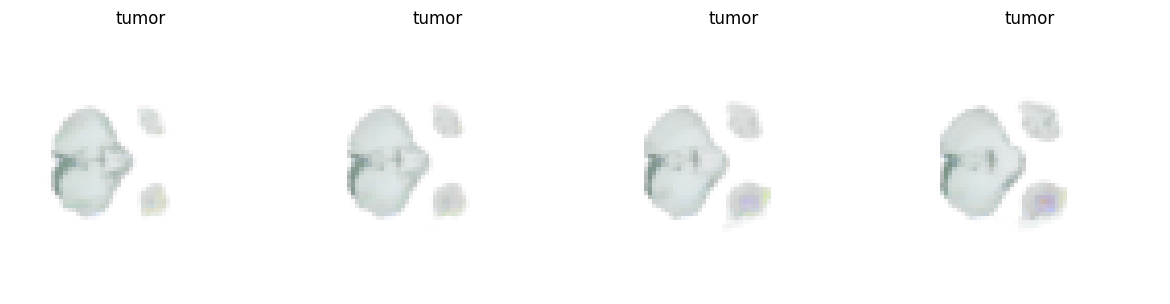

In [4]:
all_slices, all_labels = [], []
for f in tqdm(image_files, desc='Extrayendo slices'):
    img, mask = load_pair(f)
    sl, la = extract_slices(img, mask, axis=2, step=2)  # toma 1 de cada 2 para aligerar
    all_slices.extend(sl)
    all_labels.extend(la)
all_slices = np.stack(all_slices)          # [N, H, W]
all_labels = np.array(all_labels)
print('Total slices:', all_slices.shape, 'positivos:', all_labels.sum())

# Distribución
sns.countplot(x=all_labels)
plt.title('Distribución de clases (slice-level)')
plt.show()

# Mostrar ejemplos
fig, ax = plt.subplots(1,4, figsize=(12,3))
pos_indices = np.where(all_labels==1)[0][:4]
for i,idx in enumerate(pos_indices):
    ax[i].imshow(all_slices[idx], cmap='gray')
    ax[i].set_title('tumor')
    ax[i].axis('off')
plt.tight_layout()

print('Total slices:', all_slices.shape, 'positivos:', all_labels.sum())


## 3. Balanceo (undersampling) y split

In [1]:
from imblearn.under_sampling import RandomUnderSampler

# Aplanar cada slice
X = all_slices.reshape(len(all_slices), -1)
y = all_labels

rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X, y)
print('Tras balanceo:', Counter(y_bal))

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
print(X_train.shape, X_test.shape)


NameError: name 'all_slices' is not defined

## 4. Reducción de dimensionalidad con PCA

In [ ]:
pca = PCA(n_components=0.95, svd_solver='full')  # conserva 95% varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)
print('Shape tras PCA:', X_train_pca.shape)


## 5. Clasificador baseline (LogisticRegression)

In [ ]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Matriz de confusión')
plt.show()


## 6. Próximos pasos  
* Sustituir la etapa 5 por un **circuito cuántico** (VQC o QSVM).  
* Explorar distintos *embeddings* (angle, Hilbert‑curve, data re‑uploading, etc.).  
* Afinar la selección de *slices* (multi‑eje, 3‑D patches, etc.).  
* Añadir técnicas de *data augmentation* y/o balanceo avanzado.